In [6]:
import pandas as pd 
import numpy as np
import yfinance as yf
import seaborn as sns 
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
# plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
df = yf.download('INDY.jk', 
                 start='2010-01-01', 
                 end='2019-12-31',
                 progress=False)

df = df[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
df = df[['adj_close', 'log_rtn']].dropna(how = 'any')

In [8]:
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)  

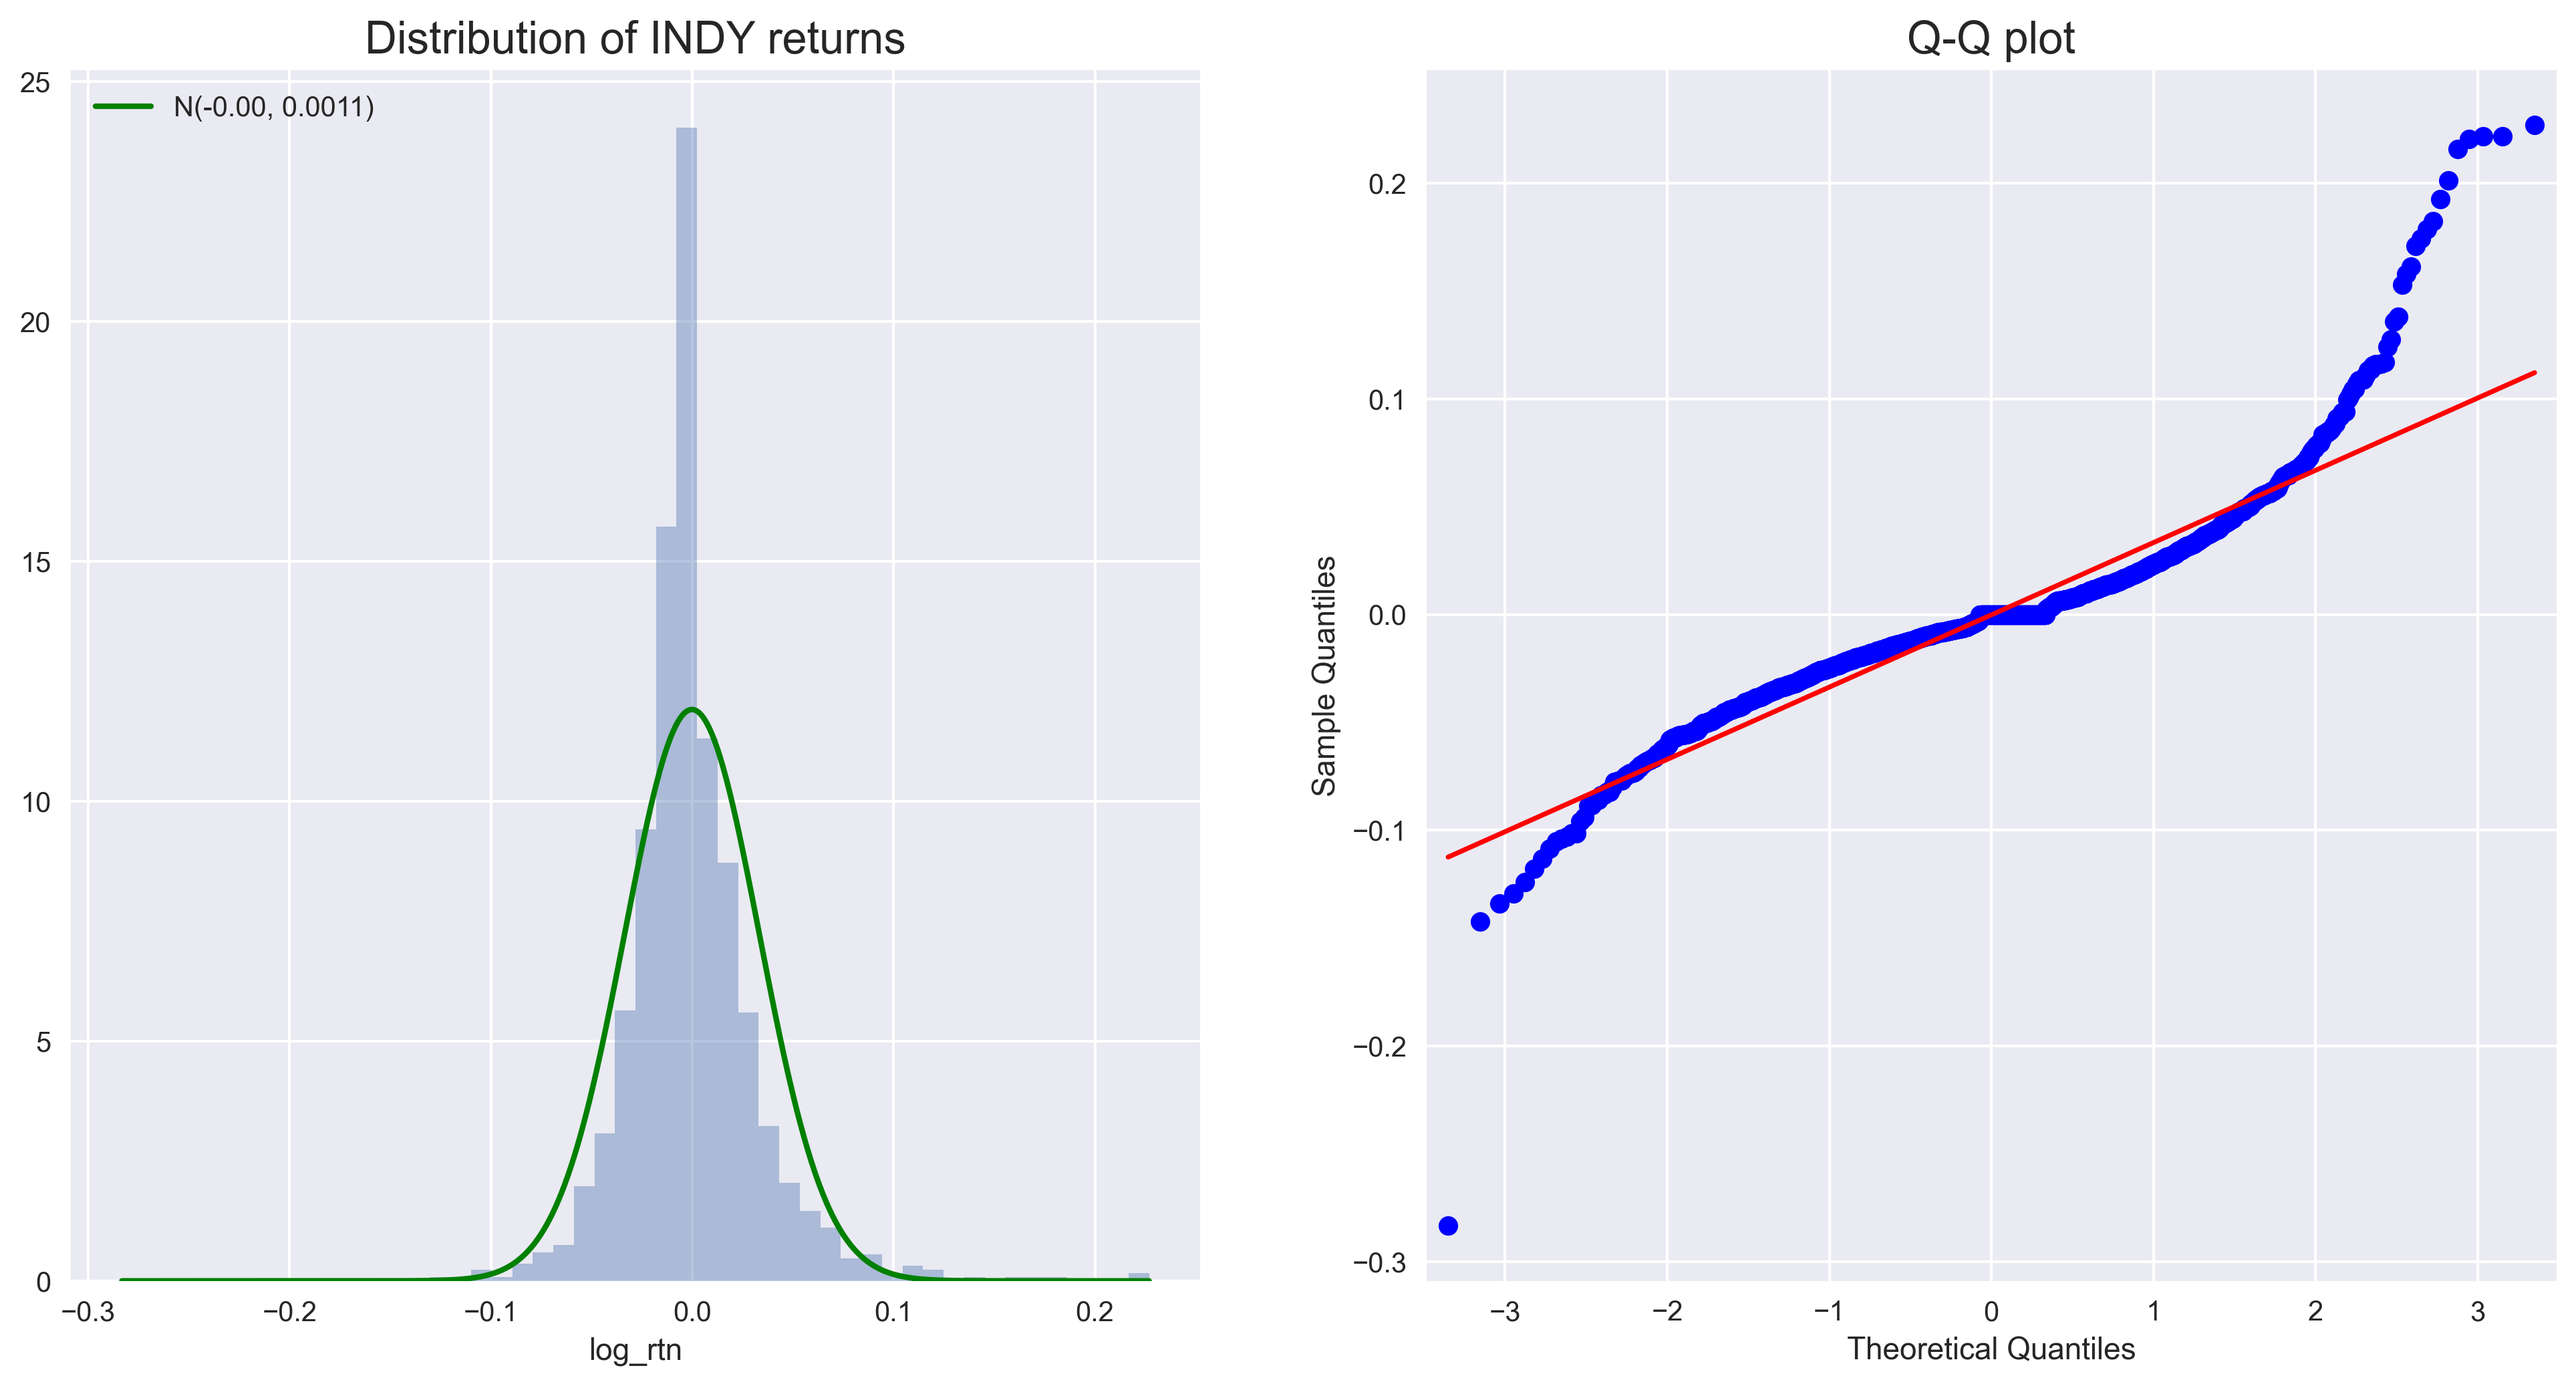

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])                                    
ax[0].set_title('Distribution of INDY returns', fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, 'g', lw=2, 
           label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

# plt.tight_layout()
plt.show()

In [10]:
jb_test = scs.jarque_bera(df.log_rtn.values)

print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness: {df.log_rtn.skew():.4f}')
print(f'Kurtosis: {df.log_rtn.kurtosis():.4f}') 
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')

---------- Descriptive Statistics ----------
Range of dates: 2010-01-05 - 2019-12-30
Number of observations: 2487
Mean: -0.0001
Median: 0.0000
Min: -0.2833
Max: 0.2269
Standard Deviation: 0.0335
Skewness: 1.0614
Kurtosis: 9.3307
Jarque-Bera statistic: 9447.37 with p-value: 0.00


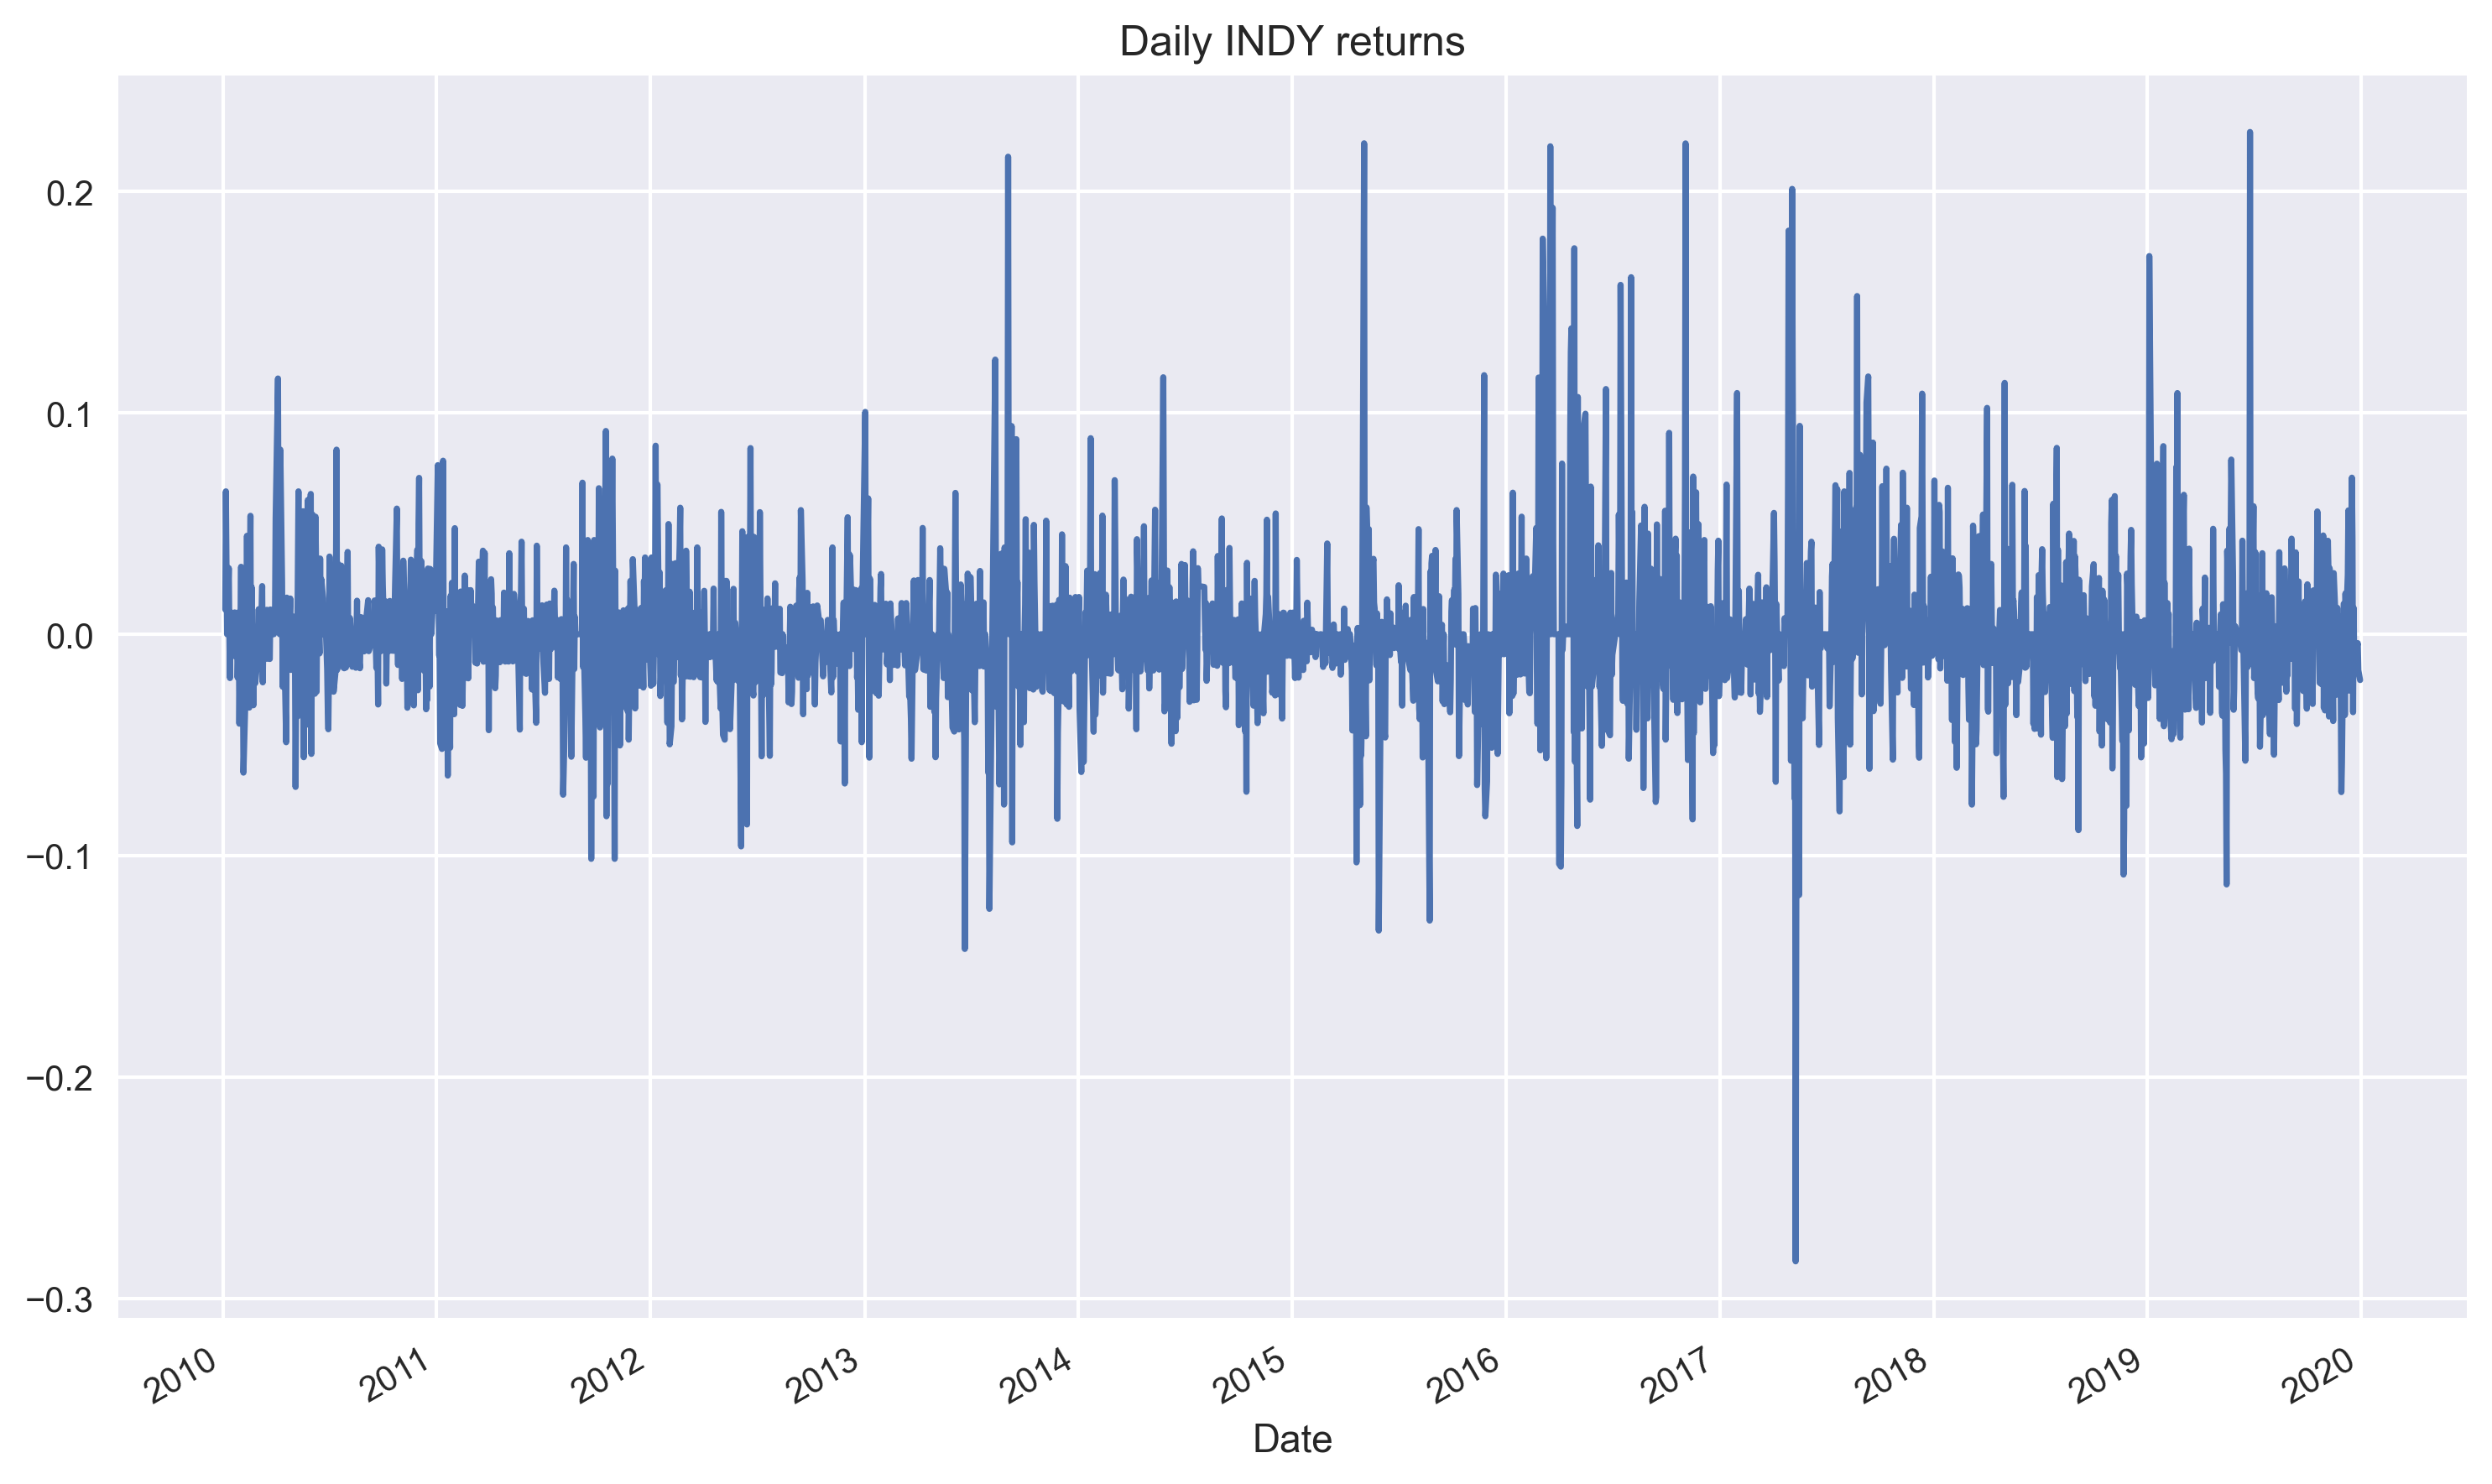

In [11]:
df.log_rtn.plot(title='Daily INDY returns', figsize=(10, 6))

plt.tight_layout()
plt.show()

In [13]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

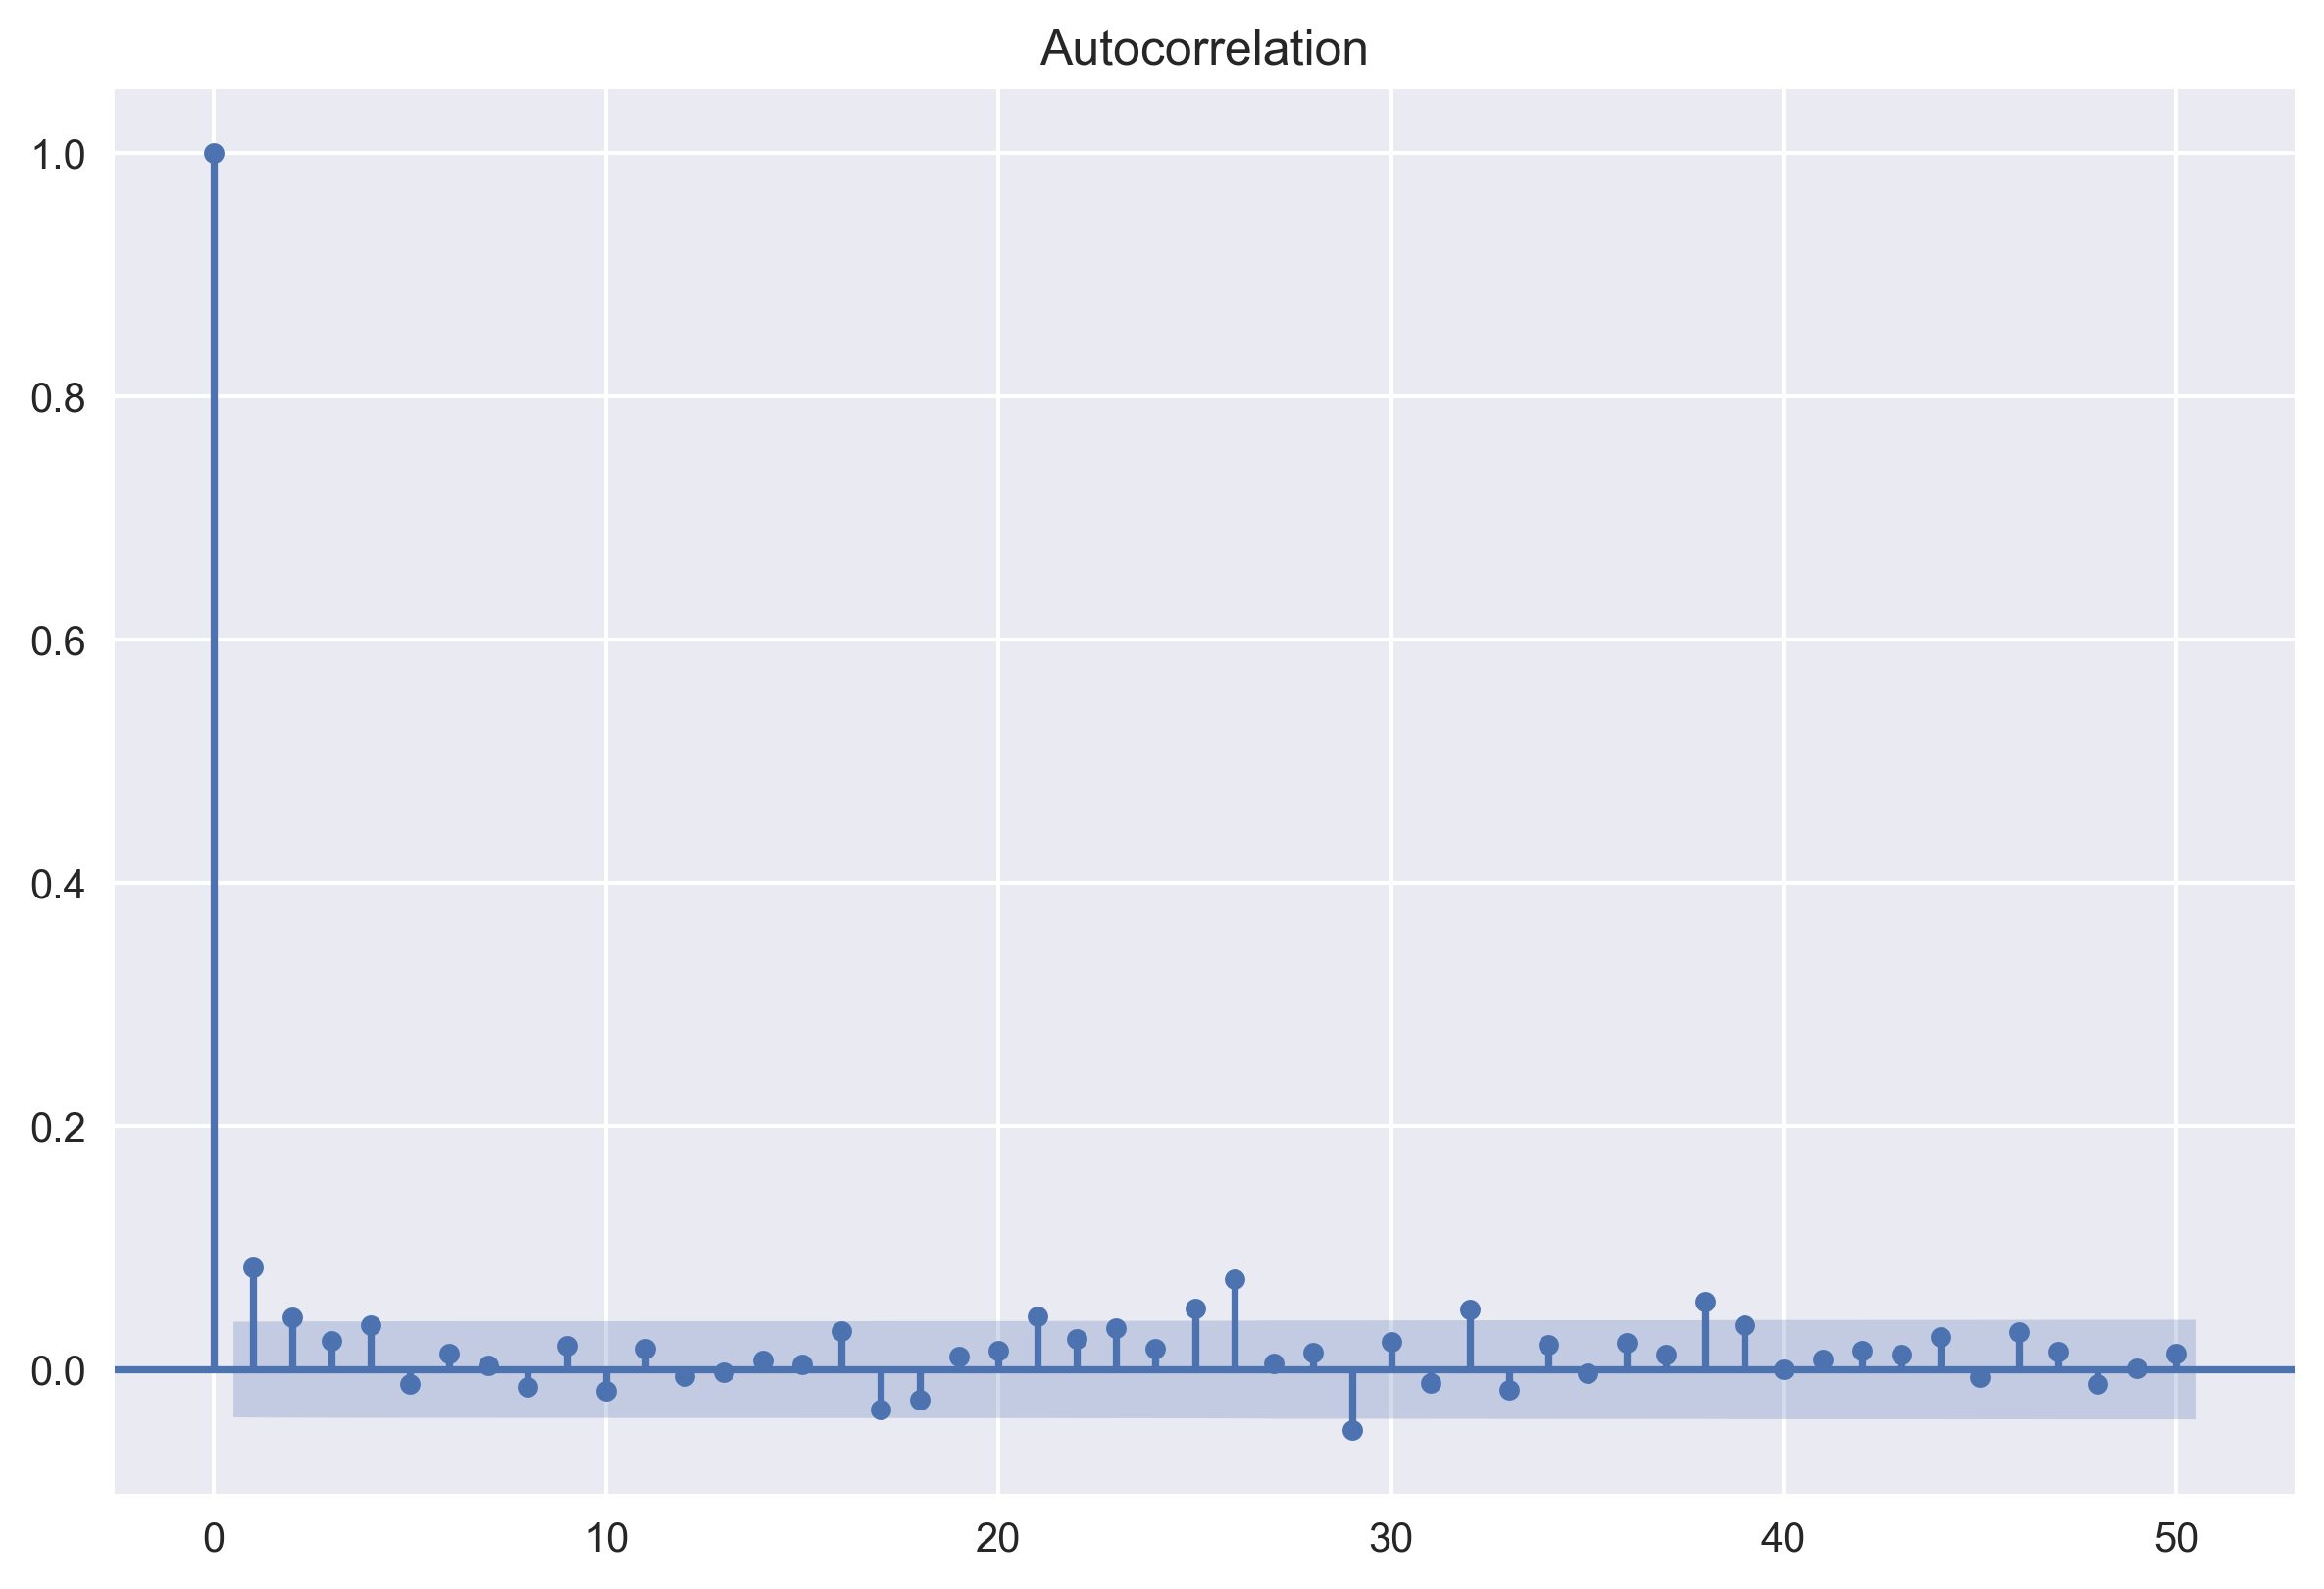

In [14]:
acf = smt.graphics.plot_acf(df.log_rtn, 
                            lags=N_LAGS, 
                            alpha=SIGNIFICANCE_LEVEL)

plt.tight_layout()
plt.show()

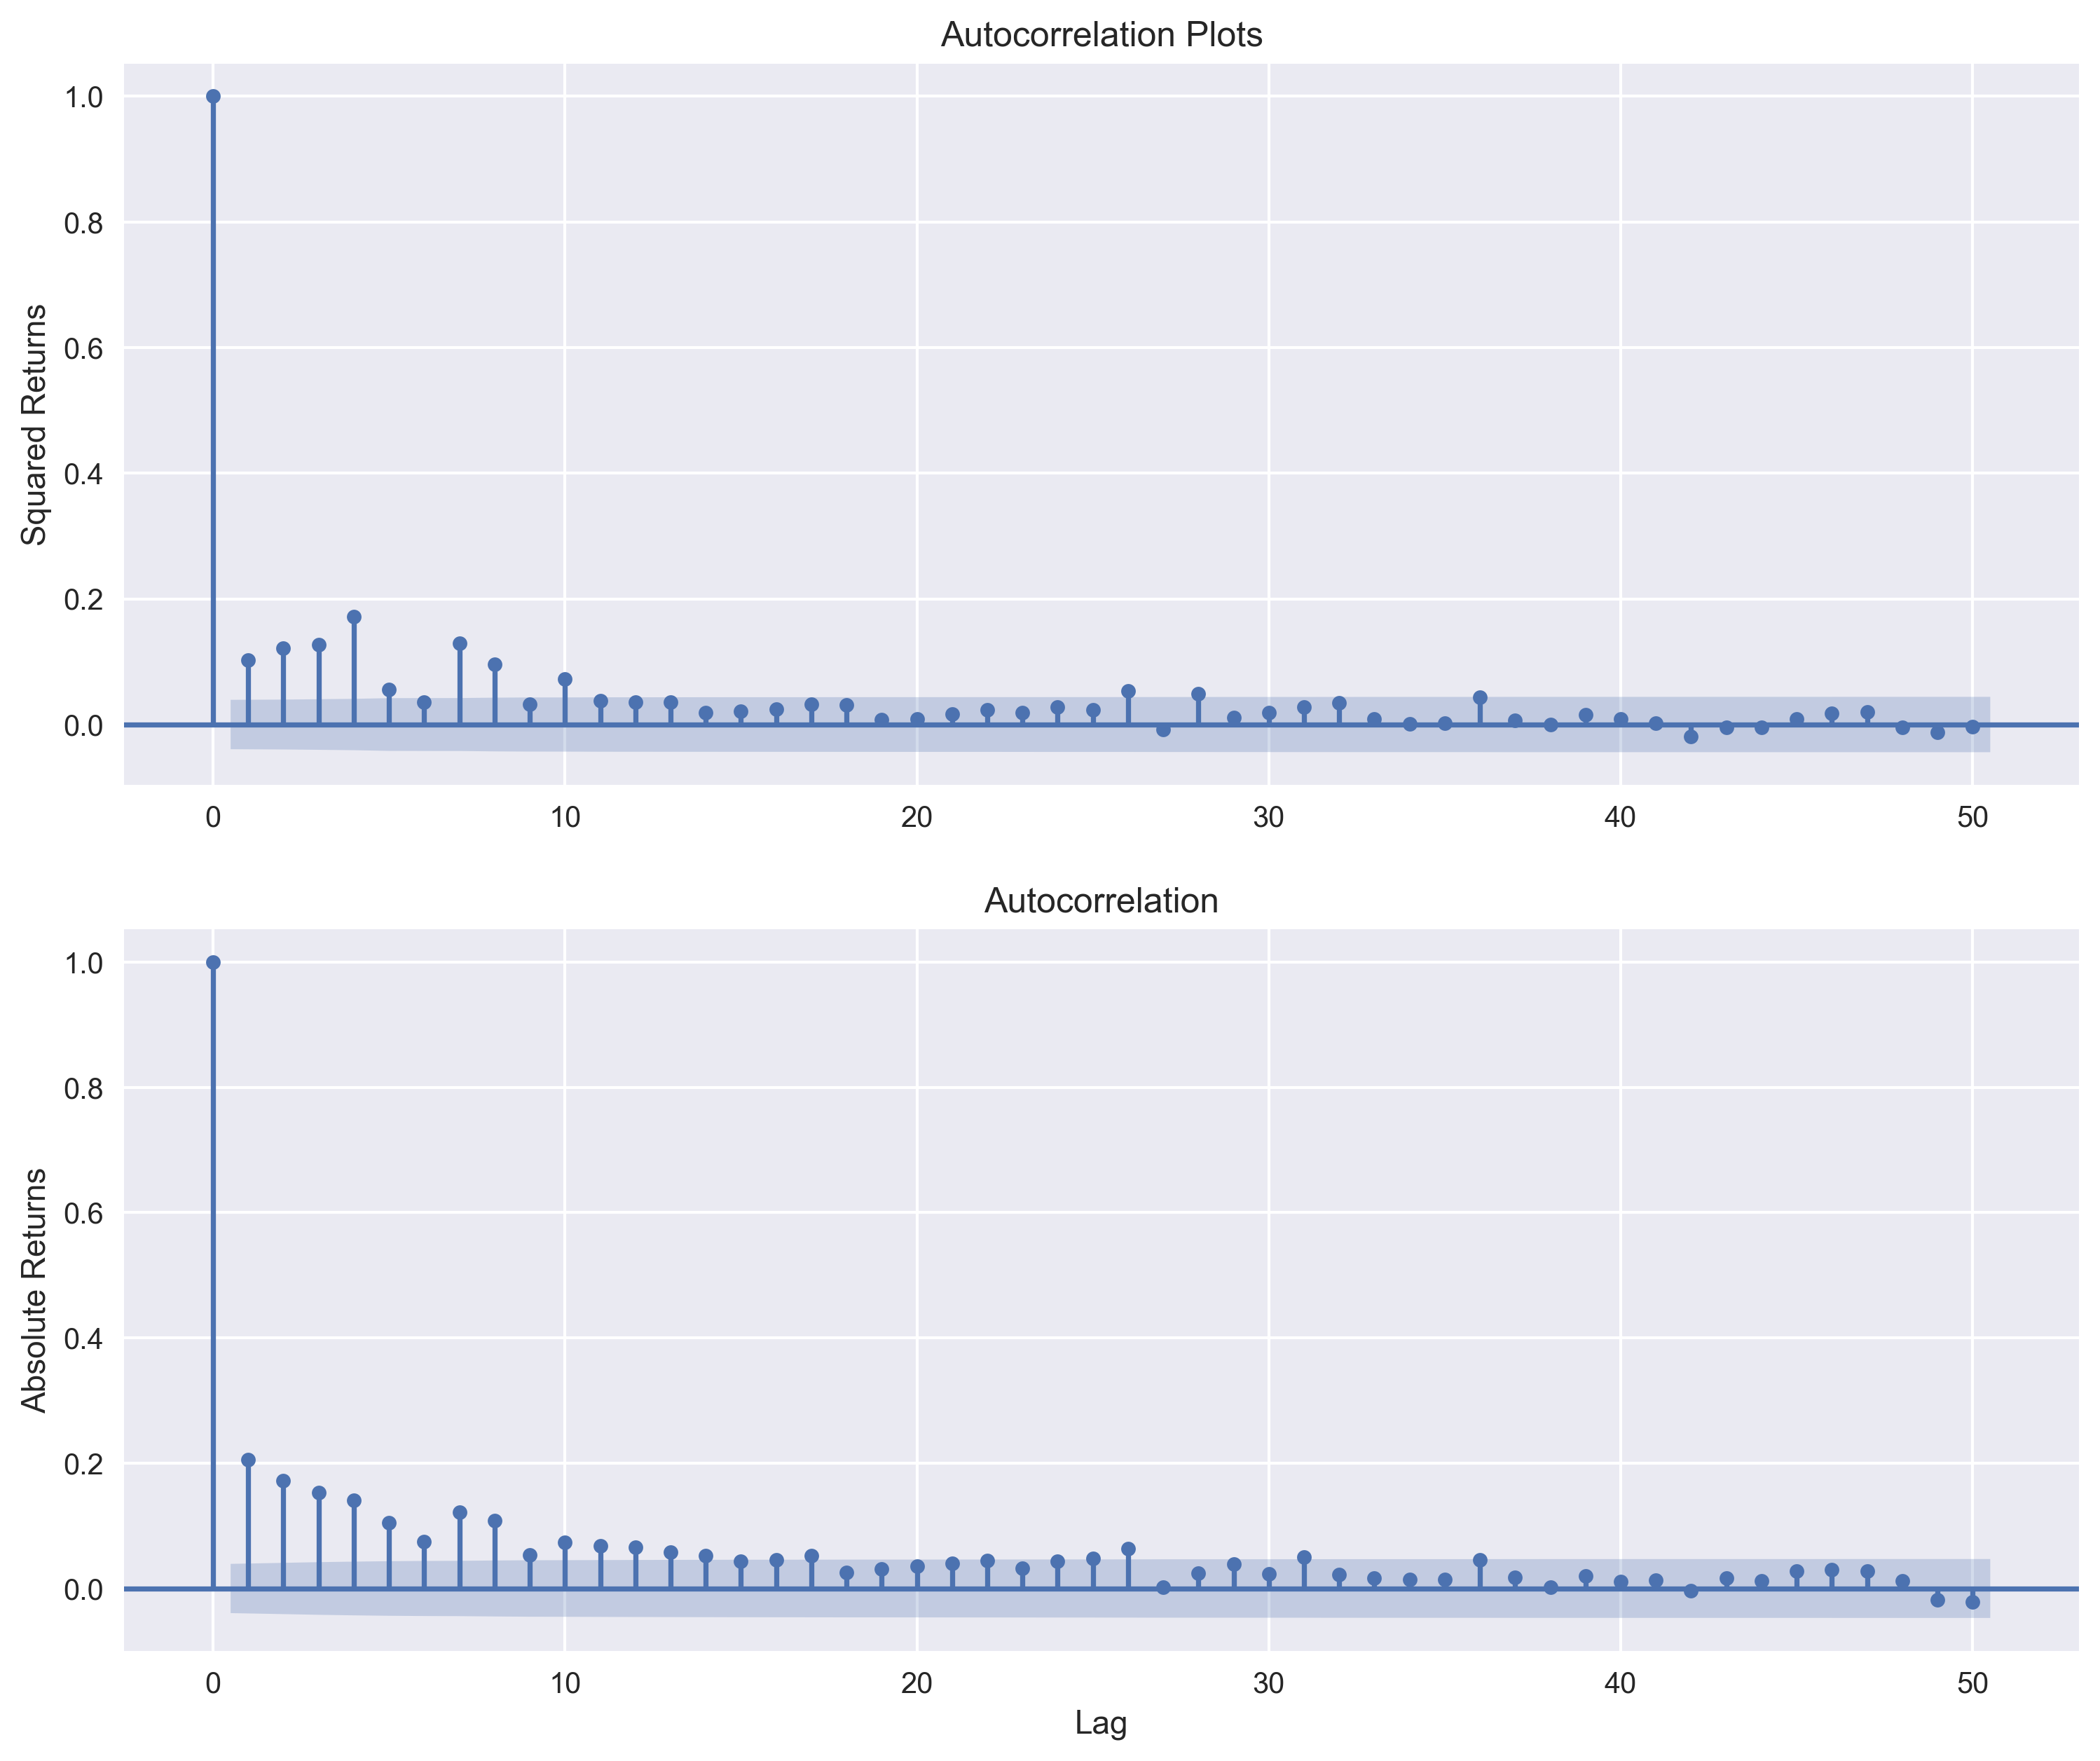

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

smt.graphics.plot_acf(df.log_rtn ** 2, lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title='Autocorrelation Plots',
          ylabel='Squared Returns')

smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel='Absolute Returns',
          xlabel='Lag')

# plt.tight_layout()
plt.show()

In [16]:
df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std()

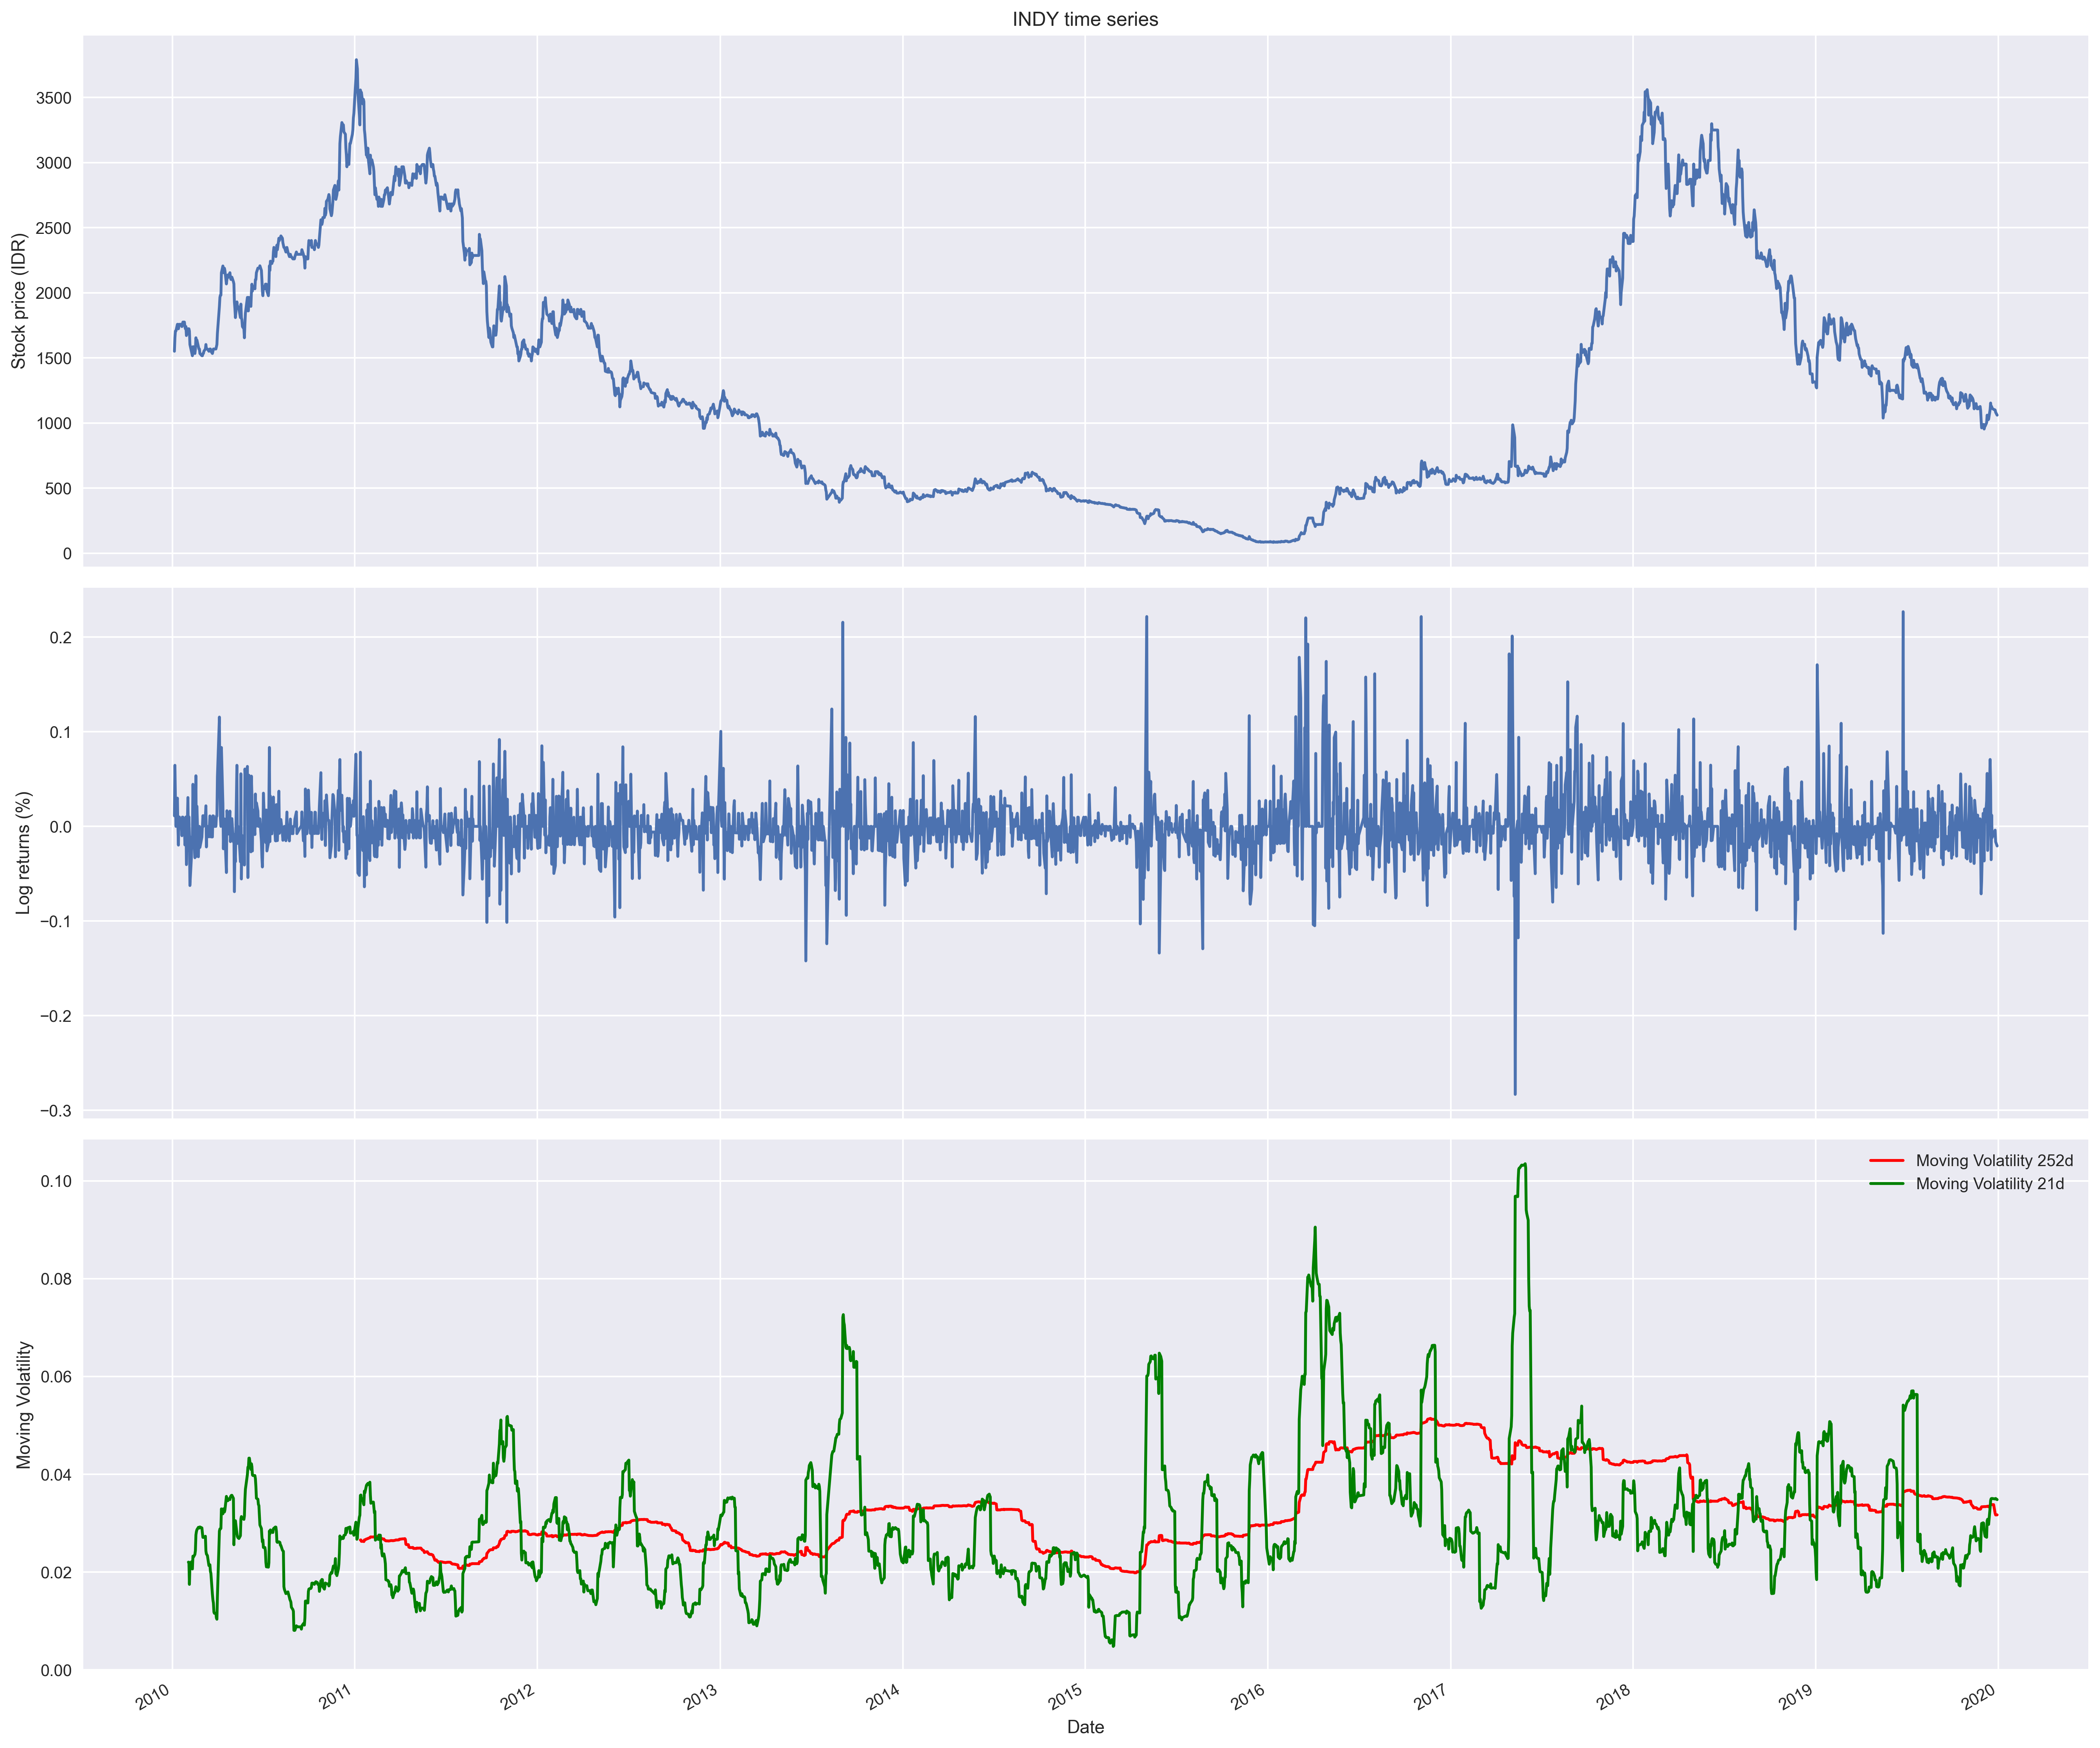

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15), 
                       sharex=True)

df.adj_close.plot(ax=ax[0])
ax[0].set(title='INDY time series',
          ylabel='Stock price (IDR)')

df.log_rtn.plot(ax=ax[1])
ax[1].set(ylabel='Log returns (%)')

df.moving_std_252.plot(ax=ax[2], color='r', 
                       label='Moving Volatility 252d')
df.moving_std_21.plot(ax=ax[2], color='g', 
                      label='Moving Volatility 21d')
ax[2].set(ylabel='Moving Volatility',
          xlabel='Date')
ax[2].legend()

plt.tight_layout()
plt.show()

In [28]:
df = yf.download(['INDY.JK', '^VIX'], 
                 start='2010-01-01', 
                 end='2019-12-31',
                 progress=False)
df = df[['Adj Close']]
df.columns = df.columns.droplevel(0)
df = df.rename(columns={'INDY.JK': 'indy', '^VIX': 'vix'})

In [29]:
df['log_rtn'] = np.log(df.indy / df.indy.shift(1))
df['vol_rtn'] = np.log(df.vix / df.vix.shift(1))
df.dropna(how='any', axis=0, inplace=True)

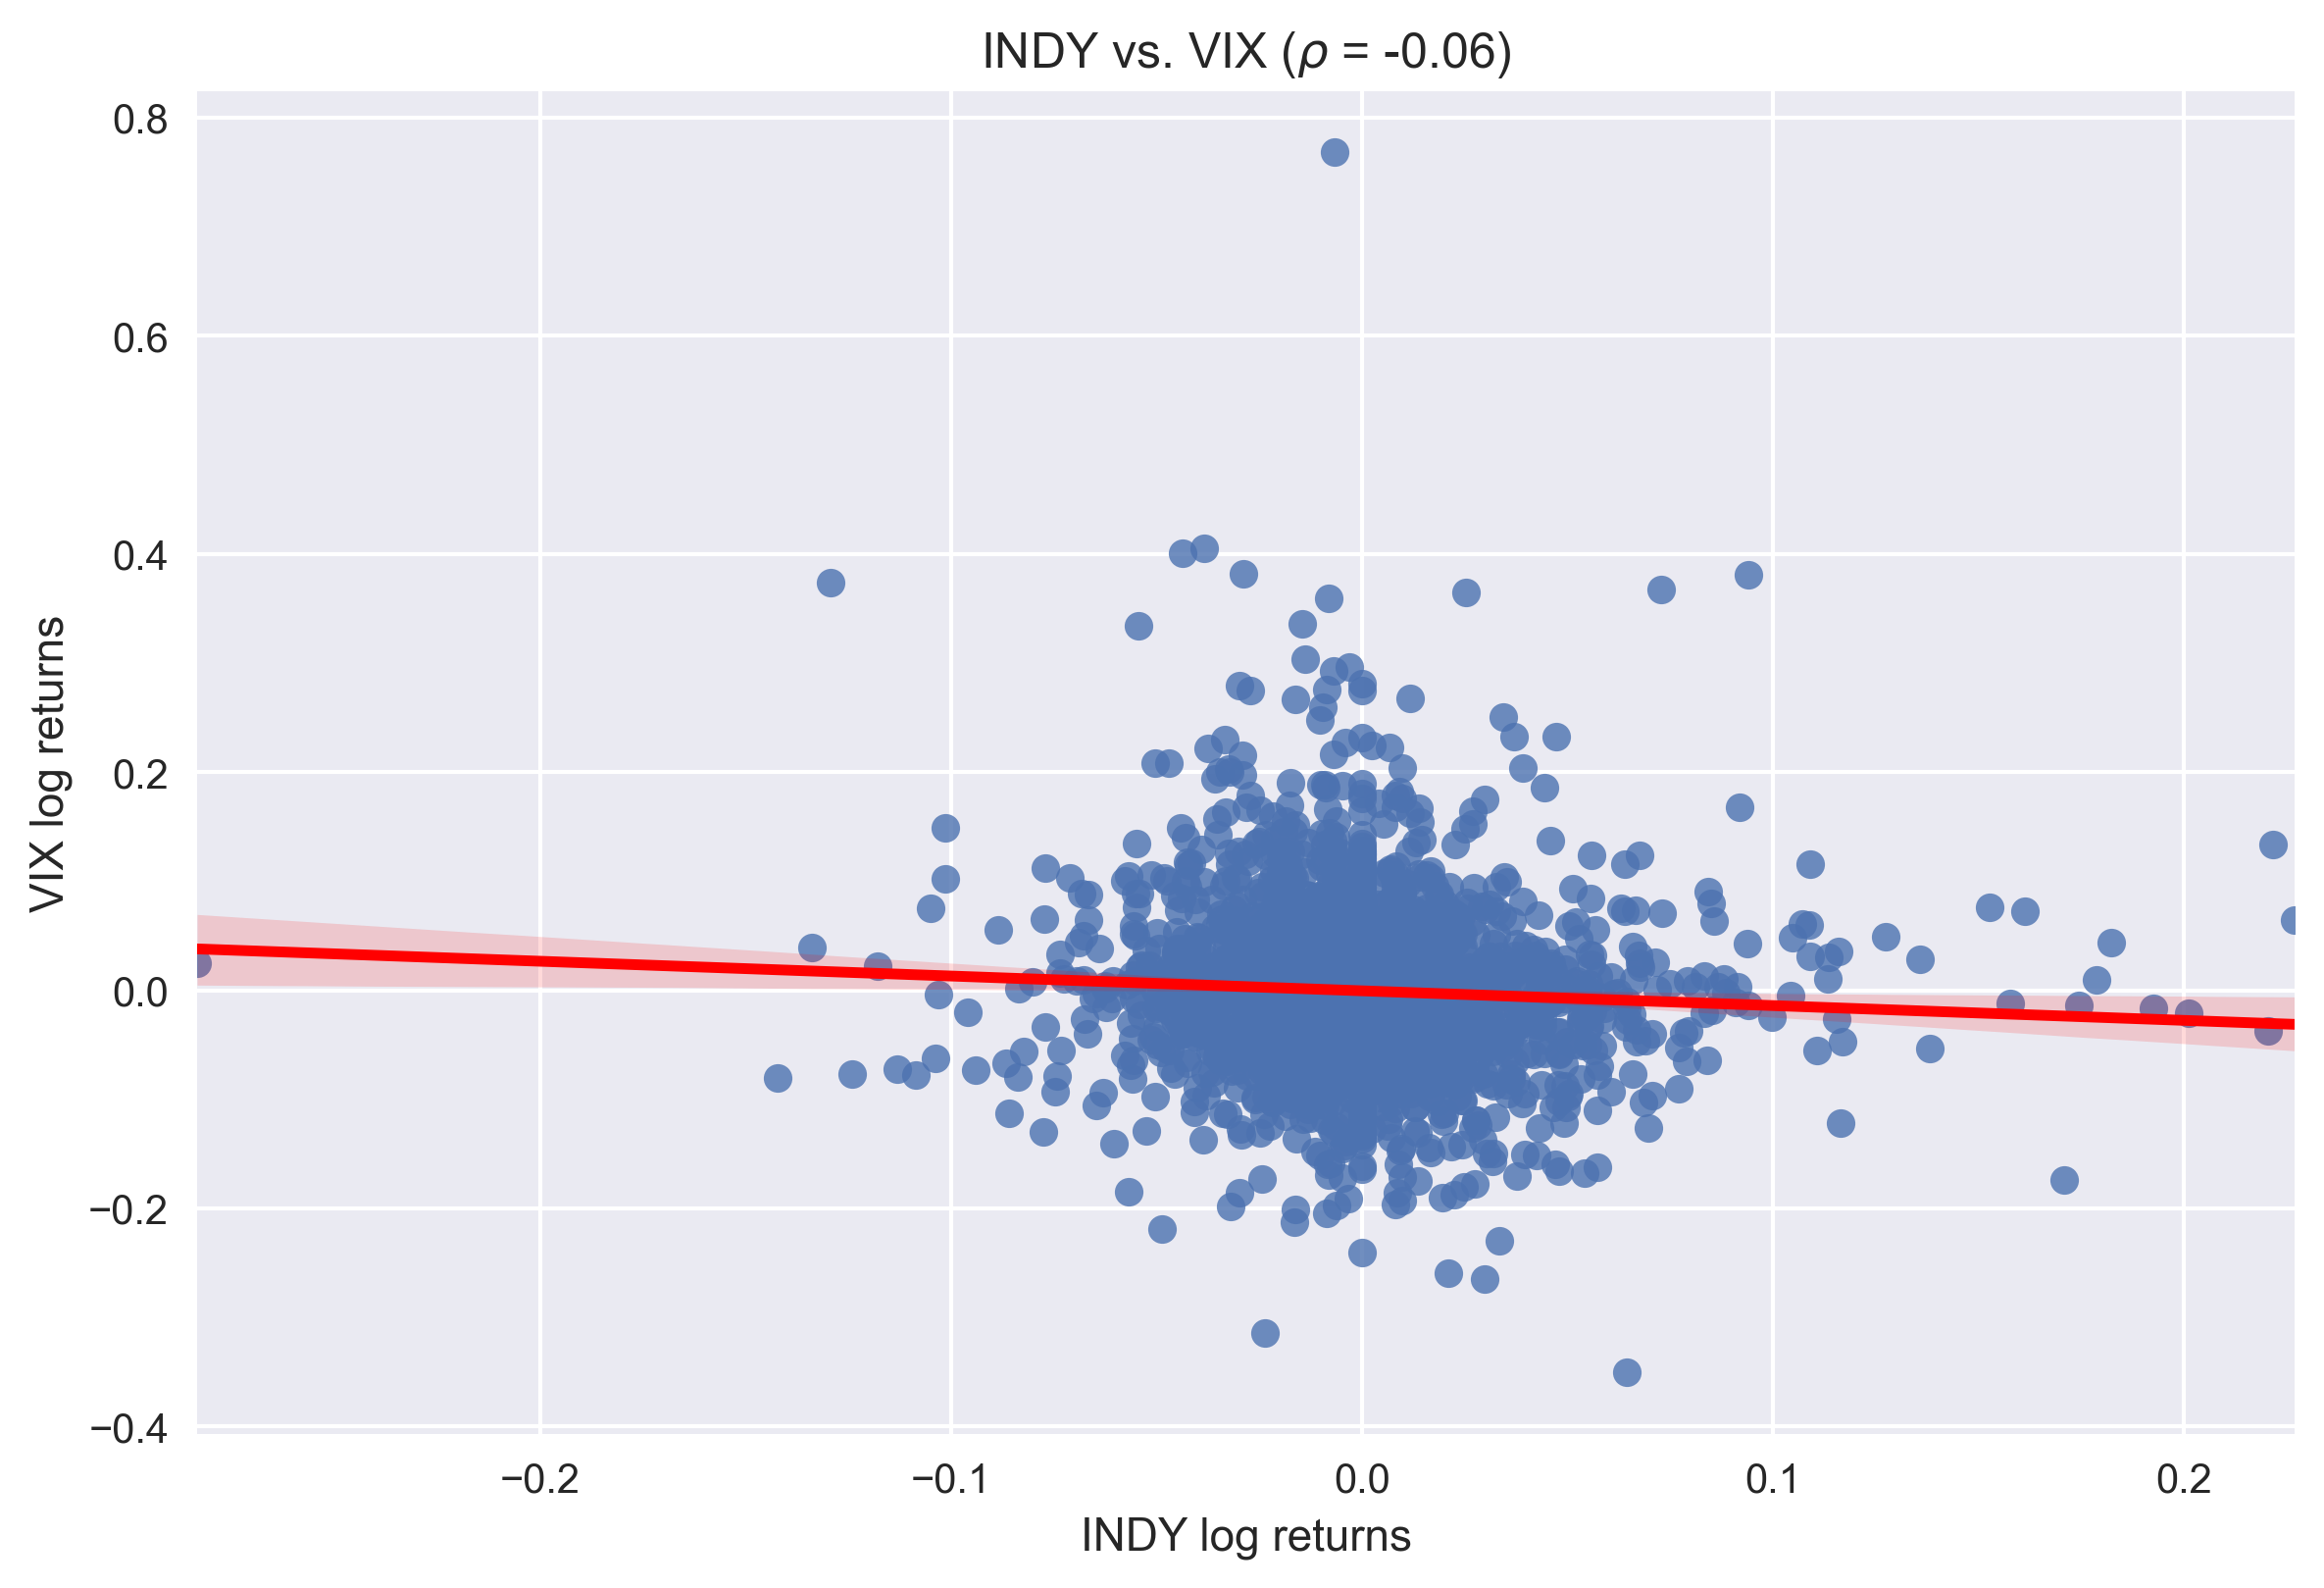

In [30]:
corr_coeff = df.log_rtn.corr(df.vol_rtn)

ax = sns.regplot(x='log_rtn', y='vol_rtn', data=df, 
                 line_kws={'color': 'red'})
ax.set(title=f'INDY vs. VIX ($\\rho$ = {corr_coeff:.2f})',
       ylabel='VIX log returns',
       xlabel='INDY log returns')

plt.tight_layout()
plt.show()